In [18]:
import pandas as pd
import ray
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                    StratifiedKFold, StratifiedShuffleSplit,
                                    cross_val_score)
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
import numpy as np
import joblib
from pandarallel import pandarallel
from sklearn.preprocessing import LabelEncoder, StandardScaler
import re

In [460]:
def busqueda(expression,column,name=None):
    if column is np.nan:
        return np.nan
    m = re.search(expression,column)
    if m == None:
        return np.nan
    if name != None:
        return name
    else :
        return m.group(0)

In [1003]:
df_1 = pd.read_csv("/home/marcelo/nico/MasivasData/Skiff_zari_gaia_OGLE_Splus_vsxpredicted.csv")

/tmp/ipykernel_4561/3900493079.py:1: DtypeWarning: Columns (72,83,84,85,86,88,89,105,122,125,127,130,131,133,134,141,163,166,167,186,193,211) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv("/home/marcelo/nico/MasivasData/Skiff_zari_gaia_OGLE_Splus_vsxpredicted.csv")


In [944]:
skiff = df_1[['source_id_1',"skiff_type",'Bibcode','GroupID_2arcsec_skiff']].astype(str)

In [945]:
skiff['skiff_type'] = skiff['skiff_type'].replace('nan', np.nan)
skiff['Bibcode'] = skiff['Bibcode'].replace('nan', np.nan)
skiff['GroupID_2arcsec_skiff'] = skiff['GroupID_2arcsec_skiff'].replace('nan', np.nan)

In [946]:
skiff = skiff.loc[skiff['skiff_type'].notna()]

In [947]:
skiff["skiff_mk"] = skiff.apply(lambda row: busqueda(r"^(?!.*[+/])[a-zA-Z]\d+(?:\.\d+)?",row["skiff_type"]),axis=1)

In [948]:
skiff.loc[(skiff['skiff_mk'].isna())&(skiff['skiff_type'].str[:2]=='em'),'skiff_mk'] = 'em_WR_Be'
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"WR|WN|WC", row["skiff_type"],'em_WR_Be'), axis=1)
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"Be", row["skiff_type"],'em_WR_Be'), axis=1)
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"OB", row["skiff_type"]), axis=1)

In [949]:
skiff.loc[(skiff['skiff_mk'].isna())&(skiff['skiff_type'].str[0]=='h'),'skiff_mk'] = skiff.loc[(skiff['skiff_mk'].isna())&(skiff['skiff_type'].str[0]=='h')]['skiff_type'].str[1:3]

In [950]:
def busqueda_2(pattern, string, default=None):
    match = re.search(pattern, string)
    if match:
        return match.group(1)  # Retornamos el primer grupo de captura
    return default

skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda_2(r"^(.*?)(?=(V|IV|III|II|Ia|Ib|Iab)(?:/(V|IV|III|II|Ia|Ib|Iab))?$)", row["skiff_type"]), axis=1)


In [951]:
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"^(O|B|A|F|G|K|M)$", row["skiff_type"]), axis=1)


In [952]:
skiff.loc[(skiff['skiff_type']=='Ofe'),'skiff_mk'] = 'em_WR_Be'

In [953]:
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"e", row["skiff_type"],'em_WR_Be'), axis=1)


In [954]:
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"^(O|B|A|F|G|K|M|N)(\d*(\.\d*)?)?(\/(\d*(\.\d*)?)?)?", row["skiff_type"]), axis=1)

In [955]:
skiff_mk = skiff.loc[(skiff['skiff_mk']!='em_WR_Be')&(skiff['skiff_mk']!='OB')&(skiff['skiff_mk'].notna())]

In [956]:
skiff_mk['skiff_mk'] = skiff_mk['skiff_mk'].str.replace('.', '')

/tmp/ipykernel_4561/2992802417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skiff_mk['skiff_mk'] = skiff_mk['skiff_mk'].str.replace('.', '')


In [957]:
replace_map = {
    'O': '0.',
    'B': '1.',
    'A': '2.',
    'F': '3.',
    'G': '4.',
    'K': '5.',
    'M': '6.'
}

In [958]:
skiff_mk['skiff_mk'] = skiff_mk['skiff_mk'].replace(replace_map, regex=True)


/tmp/ipykernel_4561/2936214468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skiff_mk['skiff_mk'] = skiff_mk['skiff_mk'].replace(replace_map, regex=True)


In [959]:
import re

def extract_first_float(s):
    match = re.search(r"(\d{1,2}(?:\.\d{1,2})?)", s)
    return float(match.group()) if match else None

s = '0.97Ib + 0.9'
number = extract_first_float(s)
print(number)


0.97


In [960]:
skiff_mk[['skiff_mk','skiff_type']]

,skiff_mk,skiff_type
62,1.5,B5V
65,0.95/,O9.5/B0
66,1.3,B3IV
85,1.7,B7V
88,0.9/95,O9/9.5
...,...,...
1089877,3.3,hF3
1089889,2.3,A3 wl
1089898,1.8,B8Ib
1089908,1.1/2,B1/2


In [961]:
n1 = skiff_mk['skiff_mk'].str.split('/').str[0]

In [962]:
n1 = n1.apply(extract_first_float)

In [963]:
n2 = skiff_mk['skiff_mk'].str.split('/').str[1].replace(np.nan,0).replace('',0).astype(str)

In [964]:
n2  = '0.'+n2

In [965]:
n2 = n2.apply(extract_first_float)

In [966]:
skiff_mk['label'] = n1+n2 /2

/tmp/ipykernel_4561/1147559748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skiff_mk['label'] = n1+n2 /2


In [967]:
import numpy as np

# Define los posibles valores
values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Selecciona las filas donde la longitud de 'skiff_type' es 1
mask = skiff_mk['skiff_type'].str.len() == 1

# Suma el valor en 'skiff_mk' con un valor aleatorio de 'values' y asigna el resultado a 'label'
skiff_mk.loc[mask, 'label'] = skiff_mk.loc[mask, 'label'] + np.random.choice(values, size=sum(mask))



In [968]:
skiff_mk["year"] = skiff_mk.apply(lambda row: busqueda(r"\d{4}",row["Bibcode"]),axis=1)  

/tmp/ipykernel_4561/1796147024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skiff_mk["year"] = skiff_mk.apply(lambda row: busqueda(r"\d{4}",row["Bibcode"]),axis=1)


In [969]:
skiff_mk["arxiv"] = skiff_mk.apply(lambda row: busqueda(r"arXiv",row["Bibcode"]),axis=1)  

/tmp/ipykernel_4561/1077858668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skiff_mk["arxiv"] = skiff_mk.apply(lambda row: busqueda(r"arXiv",row["Bibcode"]),axis=1)


In [970]:
skiff_mk.loc[df_1["arxiv"].notna(),"year"] = "20" + skiff_mk.loc[df_1["arxiv"].notna()]["year"].astype("str").str[:2]

In [971]:
skiff_mk["year"] = pd.to_numeric(skiff_mk["year"],errors="coerce")

/tmp/ipykernel_4561/745733071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skiff_mk["year"] = pd.to_numeric(skiff_mk["year"],errors="coerce")


In [972]:
# si realmente es el mismo objeto
#keywoard de los papers S/N y/o R
# Pasar a numeros los tipos espectrales redondear!
# Escribir en la tesis como determinar tipos espectrales
stars_unicas = skiff_mk.loc[skiff_mk["GroupID_2arcsec_skiff"].isna()]
star_no_unicas = skiff_mk.loc[skiff_mk["GroupID_2arcsec_skiff"].notna()]
#df_1 = pd.concat([stars_unicas,star_no_unicas])

In [973]:
# Calcula la desviación estándar dentro de cada grupo
std_by_group = star_no_unicas.groupby("GroupID_2arcsec_skiff")["label"].transform("std")

# Agrega la columna al DataFrame
star_no_unicas["std_sp"] = std_by_group

/tmp/ipykernel_4561/396490030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_no_unicas["std_sp"] = std_by_group


In [974]:
star_no_unicas = star_no_unicas.loc[(star_no_unicas["std_sp"]<0.5)|(star_no_unicas["std_sp"].isna())]

In [975]:
mean_by_group = star_no_unicas.groupby("GroupID_2arcsec_skiff")["label"].transform("mean")

# Agrega la columna al DataFrame
star_no_unicas["label"] = mean_by_group

In [976]:
star_no_unicas = star_no_unicas.sort_values(by="year",ascending=False).drop_duplicates(subset="GroupID_2arcsec_skiff",keep='first')

In [1025]:
skiff_mk = pd.concat([star_no_unicas,stars_unicas])

In [1004]:
df_1 = df_1.loc[skiff_mk.index]

In [1006]:
df_1.drop(columns=['Bibcode', 'GroupID_2arcsec_skiff'], inplace=True)


In [1032]:
# Convierte la columna 'source_id_1' a int64 en ambas DataFrames
df_1['source_id_1'] = df_1['source_id_1'].astype(int)
skiff_mk['source_id_1'] = skiff_mk['source_id_1'].astype(int)

# Ahora realiza el merge
result = skiff_mk.merge(df_1, on=['source_id_1','skiff_type'], how='left')


In [1041]:
skiff_mk = pd.concat([skiff_mk[['skiff_mk', 'label', 'year', 'arxiv', 'std_sp']],df_1.loc[skiff_mk.index]],axis=1)

In [1043]:
skiff_mk

,skiff_mk,label,year,arxiv,std_sp,source_id_1,ra_1_1,dec_1_1,ra_error,dec_error,...,h_m-phot_bp_mean_mag,h_m-phot_rp_mean_mag,ks_m-phot_g_mean_mag,ks_m-phot_bp_mean_mag,ks_m-phot_rp_mean_mag,phot_g_mean_mag-phot_bp_mean_mag,phot_g_mean_mag-phot_rp_mean_mag,phot_bp_mean_mag-phot_rp_mean_mag,vsx_split,multiplicity_probability
10288,1.5/7,1.631250,2022,NaN,0.265838,392687455423041024,4.287711,47.947390,0.042085,0.025033,...,0.189516,0.110286,0.172776,0.217516,0.138286,0.044740,-0.034490,-0.079230,no_used,0.46500
25914,0.9,0.910714,2022,NaN,0.076406,251961924258399616,58.910079,52.641319,0.043239,0.035364,...,-0.986730,-0.429297,-0.891212,-1.009730,-0.452297,-0.118518,0.438916,0.557434,no_used,0.57250
53525,1.2,1.275000,2022,NaN,0.050000,120908968675581824,52.194379,30.375297,0.024507,0.017794,...,-0.953664,-0.404502,-0.825586,-1.015664,-0.466502,-0.190079,0.359084,0.549162,no_used,0.51750
233713,1.9,1.925000,2022,NaN,0.035355,6237475867482617856,238.810822,-22.276609,0.024008,0.015315,...,-0.584461,-0.294178,-0.547940,-0.639461,-0.349178,-0.091521,0.198762,0.290283,no_used,0.46125
23136,1.5/7,1.675000,2022,NaN,0.098742,2098654306550178560,281.554203,41.441810,0.050508,0.063693,...,0.428589,0.255393,0.374833,0.446589,0.273392,0.071756,-0.101441,-0.173196,no_used,0.48250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089808,1.3/5,1.550000,1978,NaN,NaN,5533554569025442432,122.063073,-42.029828,0.023567,0.027171,...,0.655951,0.381365,0.623824,0.717122,0.442536,0.093298,-0.181288,-0.274586,train,0.53875
1089889,2.3,2.300000,1972,NaN,NaN,6602273514672096000,337.456100,-30.172504,0.017314,0.015067,...,-1.559619,-0.845363,-1.451166,-1.681182,-0.966926,-0.230016,0.484240,0.714256,train,0.21250
1089898,1.8,1.800000,1976,NaN,NaN,4658502501990777984,81.126041,-68.672987,0.013121,0.013975,...,-0.452545,-0.278547,-0.612305,-0.652143,-0.478145,-0.039838,0.134160,0.173997,train,0.39500
1089908,1.1/2,1.200000,1975,NaN,NaN,4660126759876969600,83.300032,-67.477759,0.012663,0.015406,...,0.025758,-0.023003,-0.098226,-0.046444,-0.095206,0.051781,0.003020,-0.048762,train,0.50625


In [1042]:
skiff_mk.to_csv("/home/marcelo/nico/MasivasData/skiff_2arcsec_internal_match_preprocesing.csv",index=False)

### Condiciones del paper de Zari

In [57]:
def optimize_hyperparameters(X, y):
    # Initialize a BalancedRandomForestClassifier
    clf = BalancedRandomForestClassifier()

    # Define hyperparameters grid
    param_grid = {
        'n_estimators': [200,500,800],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, None],
        'sampling_strategy': ['majority', 'not minority', 'not majority', 'all', 'auto']
    }

    # Set up k-fold cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Macro-recall scorer
    macro_recall = make_scorer(recall_score, average='macro')

    # Grid search with cross-validation
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring=macro_recall,n_jobs=-1, verbose=1)
    grid_search.fit(X, y)

    # Return best parameters and best score
    return grid_search

def preprocess_features(data,columns,bad_values):
    """
    Realiza el preprocesamiento de las características especificadas.

    Args:
    - data (pd.DataFrame): DataFrame original con los datos.

    Returns:
    - data (pd.DataFrame): DataFrame procesado con características adicionales y filas inválidas eliminadas.
    """
    
    # Busca valores 999 o -999 en las columnas especificadas
    invalid_values = data[columns].isin([bad_values, -bad_values]).sum()

    # Filtra y muestra solo las columnas que tienen estos valores inválidos
    columns_with_invalids = invalid_values[invalid_values > 0]

    if columns_with_invalids.empty:
        print(f" Todas las columnas tienen datos válidos, sin valores {bad_values} o -{bad_values}.")
    else:
        print(f"Las siguientes columnas tienen valores {bad_values} o -{bad_values}:\n{columns_with_invalids}")

    # Filtra el DataFrame para excluir filas con valores 999 o -999 en las columnas especificadas
    data = data[~data[columns].isin([bad_values, -bad_values]).any(axis=1)].reset_index(drop=True)

    return data

In [58]:
from pandarallel import pandarallel


In [59]:
pandarallel.initialize(nb_workers=12,progress_bar=True)


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [60]:
mag_features = ['j_m', 'h_m', 'ks_m','phot_g_mean_mag',
                           'phot_bp_mean_mag', 'phot_rp_mean_mag']
astrometric = [
    "parallax_error",
    "parallax_over_error",
    "pmra",
    "pmdec",
    "pmdec_error",
    "pmra_error",
    "astrometric_sigma5d_max",
    "astrometric_excess_noise",
    "visibility_periods_used",
    "ruwe",
    "astrometric_gof_al",
    "ipd_gof_harmonic_amplitude",
    "ipd_frac_odd_win",
    "ipd_frac_multi_peak",
    "matched_transits_removed",
    "astrometric_params_solved",
    "astrometric_excess_noise_sig"
]

mag_errors = ['phot_rp_mean_flux_over_error','phot_bp_mean_flux_over_error','phot_g_mean_flux_over_error','Qlf']

In [61]:
df = preprocess_features(df,mag_features+astrometric+mag_errors,np.nan)


 Todas las columnas tienen datos válidos, sin valores nan o -nan.


In [62]:
from itertools import combinations
colors =[]
for v in combinations(mag_features, 2):
    df[f"{v[0]}-{v[1]}"] = df[v[0]] - df[v[1]]
    colors.append(f"{v[0]}-{v[1]}")
    

In [63]:
class DataFrameScaler:
    def __init__(self):
        self.scalers = {}

    def scale(self, df):
        """
        Escala las columnas del DataFrame a media 0 y desviación estándar 1.
        """
        scaled_df = df.copy()
        for column in df.columns:
            scaler = StandardScaler()
            scaled_df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1)).flatten()
            self.scalers[column] = scaler
        return scaled_df

    def inverse_scale(self, df):
        """
        Devuelve el DataFrame escalado a su estado original.
        """
        original_df = df.copy()
        for column in df.columns:
            scaler = self.scalers.get(column)
            if scaler:
                original_df[column] = scaler.inverse_transform(df[column].values.reshape(-1, 1)).flatten()
        return original_df


In [64]:
from sklearn.preprocessing import StandardScaler

scaler = DataFrameScaler()
df[mag_features + colors + astrometric + mag_errors] = scaler.scale(df[mag_features + colors + astrometric + mag_errors])
# original_df = scaler.inverse_scale(scaled_df)

In [67]:
skiff.loc[skiff['numeric_sp_labels']<1.2,'label'] = 1
skiff.loc[skiff['numeric_sp_labels']>=1.2,'label'] = 0

In [68]:
skiff.loc[skiff['label']==1]['skiff_type']

917291        O2/6
11576      B1.5(e)
931193        O2/6
11953           O7
974974          O9
            ...   
1088096        B/A
1088832         B0
1088934         B1
1089658          B
1089908       B1/2
Name: skiff_type, Length: 5916, dtype: object

In [219]:
X = df[mag_features + colors + astrometric + mag_errors]
y = df['label']

In [220]:
grid_search =  optimize_hyperparameters(X, y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/home/marcelo/anaconda3/envs/splus/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [221]:
grid_search.best_score_

0.8598465399317641

In [222]:
feature_importances = grid_search.best_estimator_.feature_importances_
features = X.columns
sorted_features = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)

In [223]:
sorted_features

[('parallax_over_error', 0.15252719513773166),
 ('phot_bp_mean_flux_over_error', 0.05994884585573608),
 ('phot_bp_mean_mag-phot_rp_mean_mag', 0.03850330876735345),
 ('phot_g_mean_mag-phot_bp_mean_mag', 0.03792320858236627),
 ('pmra', 0.03272393803656359),
 ('phot_g_mean_mag-phot_rp_mean_mag', 0.029809405721543565),
 ('pmdec', 0.02914393166230886),
 ('phot_rp_mean_flux_over_error', 0.02853466054798406),
 ('parallax_error', 0.027539754806998603),
 ('phot_g_mean_flux_over_error', 0.02647867878590352),
 ('j_m-phot_bp_mean_mag', 0.024449912558084035),
 ('phot_bp_mean_mag', 0.024180148268289903),
 ('pmra_error', 0.02359948541773404),
 ('astrometric_sigma5d_max', 0.02250151925710377),
 ('ks_m', 0.02243991819403014),
 ('h_m', 0.021804157292738942),
 ('h_m-phot_bp_mean_mag', 0.021317650112193227),
 ('j_m-phot_rp_mean_mag', 0.021022740098883504),
 ('phot_g_mean_mag', 0.020455219193162028),
 ('j_m', 0.020453738309800313),
 ('j_m-ks_m', 0.020415261699401947),
 ('pmdec_error', 0.0203734596202928),


In [122]:
# no puedo perdecir etiqueta 2 
# agregaría los 3 labels!

In [124]:
df_rf = df.loc[df["label"]!=2][["pmdec","parallax","pmra","label"]+colors]

              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     10435
         1.0       0.12      0.82      0.21       342

    accuracy                           0.81     10777
   macro avg       0.56      0.81      0.55     10777
weighted avg       0.97      0.81      0.87     10777



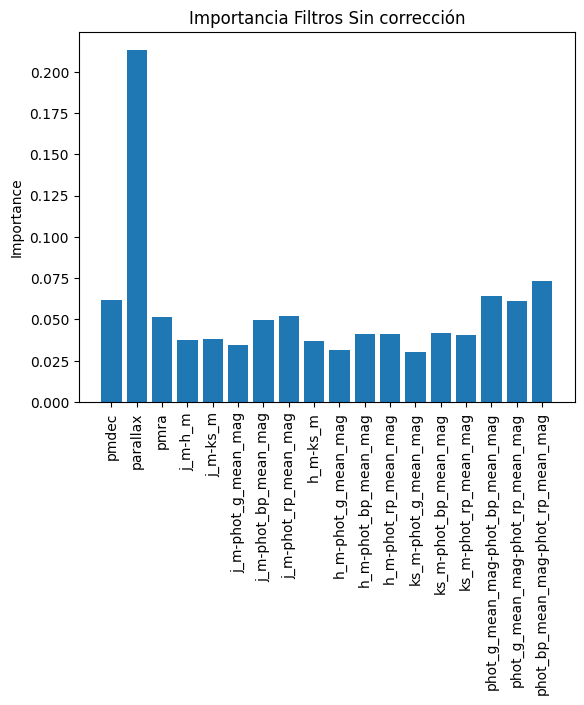

In [125]:
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop(columns={"label"}),
                                                    df_rf["label"], test_size=0.2, random_state=42)

df.loc[X_train.index,"split"] = "train"
df.loc[X_test.index,"split"] = "test"

# Definir el modelo
model = BalancedRandomForestClassifier(n_estimators=500,random_state=42)
model.fit(X_train, y_train)
# Revisar criterios usar ambos
# Porcentaje o numero entero en el min sample split
# Mirar la documentación y optimizar hyperparametros, sampling stategy!

y_predict = model.predict(X_test)

resultados = pd.DataFrame({"y_predict":y_predict,"y_test":y_test})

print(classification_report(y_test, y_predict))


import matplotlib.pyplot as plt

# Datos de ejemplo
x = model.feature_names_in_
y = model.feature_importances_

# Crear el gráfico de barras
plt.bar(x, y)

# Opcional: Personalizar el gráfico
plt.ylabel('Importance')
plt.title('Importancia Filtros Sin corrección')
plt.xticks(rotation='vertical')

# Mostrar el gráfico
plt.show()



In [ ]:
IFAS para medidas de Halpha, debería servir bastante para dividir Oes y Bes
Estrellas O emiten en rayos X 
 Posible idea "https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/uhb/node136.html
    https://www.vphasplus.org/ 
    https://www.iphas.org/ tiene u

In [7]:
model.predict(df[["pmdec","parallax","pmra"]+colors]) 

array([0., 0., 0., ..., 0., 0., 0.])

In [128]:
df["rf_predict"] = model.predict(df[["pmdec","parallax","pmra"]+colors]) 

In [129]:
df_1 = df.loc[df["rf_predict"]!=0]

In [138]:
df["split"]

0        train
1        train
2        train
3        train
4         test
         ...  
59894    train
59895    train
59896    train
59897    train
59898    train
Name: split, Length: 59899, dtype: object

In [143]:
df_review = df.loc[(df["rf_predict"]==1)&(df["split"]=="test")]

In [145]:
df_review.loc[df_review["label"]==0].groupby("mk").count()["name"]

mk
A     198
B    1416
F      79
G      17
K       2
M      11
Name: name, dtype: int64

In [146]:
198/1416

0.13983050847457626

In [149]:
14497/30824

0.4703153386971191

In [150]:
df_1

,name,sptype,bibcode,source_id,ra,dec,ra_error,dec_error,parallax,parallax_error,...,h_m-phot_bp_mean_mag,h_m-phot_rp_mean_mag,ks_m-phot_g_mean_mag,ks_m-phot_bp_mean_mag,ks_m-phot_rp_mean_mag,phot_g_mean_mag-phot_bp_mean_mag,phot_g_mean_mag-phot_rp_mean_mag,phot_bp_mean_mag-phot_rp_mean_mag,split,rf_predict
22,JL 76,B2V,1977MNRAS.180p..31B,6348013516630089600,322.772001,-82.681432,0.012610,0.013970,0.122137,0.015700,...,-0.267812,-0.079797,-0.120970,-0.173813,0.014203,-0.052843,0.135173,0.188016,train,1.0
50,NSV 5313,A3/6,1998A&AS..131..115C,5199521463337441152,176.050334,-80.193009,0.018525,0.019063,0.226265,0.018960,...,-1.930328,-1.031173,-1.628895,-1.990328,-1.091173,-0.361433,0.537722,0.899155,test,1.0
57,SOPS Ia-216,OB-,1972POAN....2...59S,5784536347386426624,201.243944,-79.750117,0.016352,0.015946,0.106836,0.019451,...,0.350538,0.206725,0.330375,0.383538,0.239725,0.053163,-0.090650,-0.143813,NaN,1.0
60,SOPS Ia-213,OB-,1972POAN....2...59S,5200546586130959744,166.289165,-79.362332,0.019892,0.017272,0.169451,0.021138,...,-0.069871,-0.006728,-0.031265,-0.043871,0.019272,-0.012606,0.050537,0.063143,NaN,1.0
70,SOPS Ia-209,OB,1972POAN....2...59S,5788398313259527808,186.408724,-78.797513,0.023525,0.019014,0.187114,0.024753,...,-0.479261,-0.352803,-0.626556,-0.576261,-0.449803,0.050295,0.176753,0.126458,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59869,NGC 6705 Str 663,A5:,1925LicOB..12...10T,4252502748189542400,282.813209,-6.265053,0.016050,0.020357,0.451592,0.027922,...,-1.862153,-0.948872,-1.645575,-1.989153,-1.075872,-0.343578,0.569703,0.913281,train,1.0
59883,HD 225563,A,1925AnHar.100....1C,2047732345358266240,296.035520,35.111018,0.061610,0.066032,0.407392,0.081663,...,-0.322541,-0.172670,-0.678761,-0.339541,-0.189670,0.339220,0.489091,0.149871,train,1.0
59891,HD 147792,A0,1921AnHar..96.....C,5993094663582797696,246.415740,-40.655231,0.181629,0.139302,0.490554,0.214927,...,-1.880835,-0.884265,-1.647615,-2.032835,-1.036265,-0.385220,0.611350,0.996570,test,1.0
59896,CD-40 5337,A2,1919AnHar..94.....C,5425558101706488192,143.861476,-41.451704,0.199545,0.209763,0.243878,0.291947,...,-0.374896,-0.180279,-0.832027,-0.445896,-0.251278,0.386131,0.580749,0.194618,train,1.0


In [ ]:
# se equivoca mas con las B entonces esta clasificando cosas mas azules
# Como calculo el tipo espectral representativo y estar seguro que es el mismo objeto
# Cuantos objetos cumplen los objetos de Zari y no tienen tipos expectrales --> Descargar desde simbad
# Buscar espectros para los que no esten en zari
# Otros datos
# Labels gorupby 5 tipos espectrales vemos una dispersión mayor de danto no uso el objeto
# Label hago un sigma clipping con los numeros
distribucion de las dispersiones de tipo espectrales, hacemos corte cuando se va de la normal
Para los otros que no tienen dispersones extremas me quedo con un tipo expectral mediano
Me quedo con unas coordenadas medianas y esas uso para hacer el cross match

In [148]:
df.groupby("mk").count()["name"]

mk
A    14497
B    30824
F     2976
G      380
K       68
M       61
O     7849
Name: name, dtype: int64

In [58]:
pd.set_option('display.max_row', 10)


In [ ]:
import joblib
joblib.dump(model, 'r_f_sin_correccion.joblib')

In [59]:
df_1.to_csv("candidate_to_massive_stars.csv",index=False)

In [62]:
df_1["source_id"].to_csv("source_id_Candidatas_massive_stars.csv",index=False)

## Resta colores consecutivos

In [81]:
sample = pd.read_csv("skiff_UCAC4_topcat_labels.csv")
sample = sample.loc[sample["label"]!=2].reset_index(drop=True)

mag_features = sample[['Jmag', 'Hmag', 'Kmag', 'Bmag', 'Vmag',
       'Gmag', 'Rmag', 'Imag']]


df_rf = sample[["Name","label"]].reset_index(drop=True)

combinaciones = [
    "Bmag-Vmag",
    "Vmag-Gmag",
    "Gmag-Rmag",
    "Rmag-Imag",
    "Jmag-Hmag",
    "Jmag-Kmag"]
for v in combinaciones :
    magnitudes = v.split("-")
    df_rf[v] = sample[magnitudes[0]] - sample[magnitudes[1]]

/tmp/ipykernel_22667/4136818439.py:1: DtypeWarning: Columns (5,42,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sample = pd.read_csv("skiff_UCAC4_topcat_labels.csv")


              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93     75160
         1.0       0.02      0.87      0.05       283

    accuracy                           0.87     75443
   macro avg       0.51      0.87      0.49     75443
weighted avg       1.00      0.87      0.93     75443



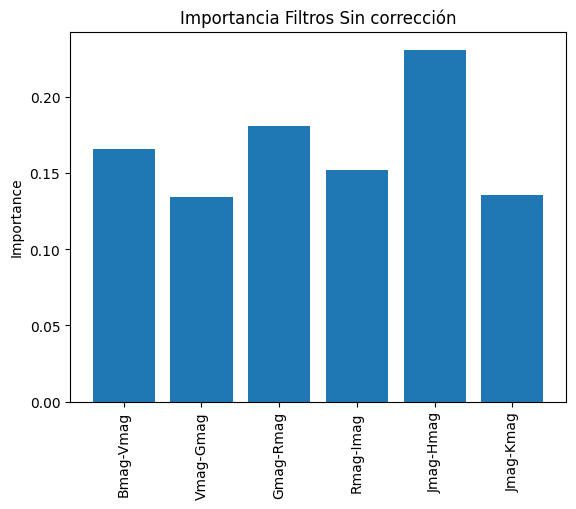

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop(columns={"Name","label"}),
                                                    df_rf["label"], test_size=0.2, random_state=42)



# Definir el modelo
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

resultados = pd.DataFrame({"y_predict":y_predict,"y_test":y_test})

print(classification_report(y_test, y_predict))


import matplotlib.pyplot as plt

# Datos de ejemplo
x = model.feature_names_in_
y = model.feature_importances_

# Crear el gráfico de barras
plt.bar(x, y)

# Opcional: Personalizar el gráfico
plt.ylabel('Importance')
plt.title('Importancia Filtros Sin corrección')
plt.xticks(rotation='vertical')

# Mostrar el gráfico
plt.show()


###  Balanced random forest corregido

In [78]:
sample = pd.read_csv("skiff_UCAC4_topcat_labels.csv")
sample = sample.loc[sample["label"]!=2].reset_index(drop=True)

data = {
    "Bmag": 3.626,
    "Vmag": 2.742,
    "Gmag": 3.303,
    "Rmag": 2.285,
    "Imag": 1.698,
    "Jmag": 0.709,
    "Hmag": 0.449,
    "Kmag": 0.302
}

coords = SkyCoord(sample["_RAJ2000"],sample["_DEJ2000"], unit='deg').galactic
sfd = SFDQuery()
sample["ebv"] = sfd(coords)

for key, value in data.items():
    sample[key] = sample[key] - (value * sample["ebv"])
    
mag_features = sample[['Jmag', 'Hmag', 'Kmag', 'Bmag', 'Vmag',
       'Gmag', 'Rmag', 'Imag']]

df_rf = sample[["Name","label"]].reset_index(drop=True)

from itertools import combinations
for v in combinations(mag_features, 2):
    df_rf[f"{v[0]}-{v[1]}"] = sample[v[0]] - sample[v[1]]

/tmp/ipykernel_22667/584730718.py:1: DtypeWarning: Columns (5,42,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sample = pd.read_csv("skiff_UCAC4_topcat_labels.csv")


The SFD'98 dust map is not in the data directory:

    /home/nico/universidad/dustmap

To change the data directory, call:

    from dustmaps.config import config
    config['data_dir'] = '/path/to/data/directory'

To download the SFD'98 map to the data directory, call:

    import dustmaps.sfd
    dustmaps.sfd.fetch()



FileNotFoundError: [Errno 2] No such file or directory: '/home/nico/universidad/dustmap/sfd/SFD_dust_4096_ngp.fits'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop(columns={"Name","label"}),
                                                    df_rf["label"], test_size=0.2, random_state=42)



# Definir el modelo
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

resultados = pd.DataFrame({"y_predict":y_predict,"y_test":y_test})

print(classification_report(y_test, y_predict))


import matplotlib.pyplot as plt

# Datos de ejemplo
x = model.feature_names_in_
y = model.feature_importances_

# Crear el gráfico de barras
plt.bar(x, y)

# Opcional: Personalizar el gráfico
plt.ylabel('Importance')
plt.title('Importancia Filtros Sin corrección')
plt.xticks(rotation='vertical')

# Mostrar el gráfico
plt.show()


## Resta consecutiva corregida

/tmp/ipykernel_6276/1201379821.py:1: DtypeWarning: Columns (5,42,47,48,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("skiff_UCAC4_topcat_labels.csv")


              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91     68640
         1.0       0.02      0.92      0.04       287

    accuracy                           0.83     68927
   macro avg       0.51      0.87      0.47     68927
weighted avg       1.00      0.83      0.90     68927



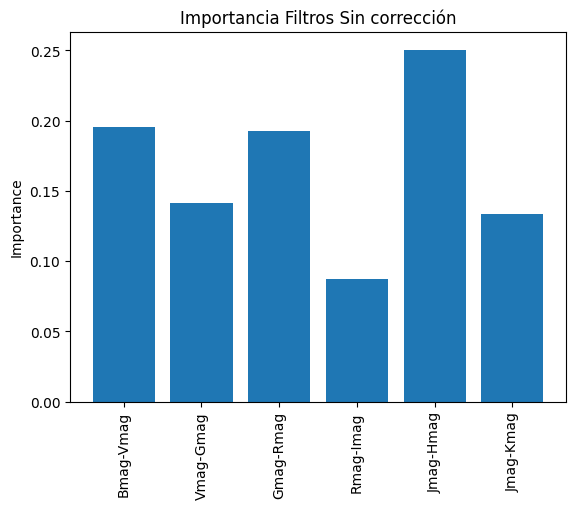

In [91]:
df = pd.read_csv("skiff_UCAC4_topcat_labels.csv")
sample = df.loc[df["prepro"]==1].reset_index(drop=True)

data = {
    "Bmag": 3.626,
    "Vmag": 2.742,
    "Gmag": 3.303,
    "Rmag": 2.285,
    "Imag": 1.698,
    "Jmag": 0.709,
    "Hmag": 0.449,
    "Kmag": 0.302
}

coords = SkyCoord(sample["_RAJ2000"],sample["_DEJ2000"], unit='deg').galactic
sfd = SFDQuery()
sample["ebv"] = sfd(coords)

for key, value in data.items():
    sample[key] = sample[key] - (value * sample["ebv"])
    
mag_features = sample[['Jmag', 'Hmag', 'Kmag', 'Bmag', 'Vmag',
       'Gmag', 'Rmag', 'Imag']]


df_rf = sample[["Name","label"]].reset_index(drop=True)

for v in combinaciones :
    magnitudes = v.split("-")
    df_rf[v] = sample[magnitudes[0]] - sample[magnitudes[1]]
    
    

X_train, X_test, y_train, y_test = train_test_split(df_rf.drop(columns={"Name","label"}),
                                                    df_rf["label"], test_size=0.2, random_state=42)



# Definir el modelo
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

resultados = pd.DataFrame({"y_predict":y_predict,"y_test":y_test})

print(classification_report(y_test, y_predict))


import matplotlib.pyplot as plt

# Datos de ejemplo
x = model.feature_names_in_
y = model.feature_importances_

# Crear el gráfico de barras
plt.bar(x, y)

# Opcional: Personalizar el gráfico
plt.ylabel('Importance')
plt.title('Importancia Filtros Sin corrección')
plt.xticks(rotation='vertical')

# Mostrar el gráfico
plt.show()


### Pareciera que lo que anda mejor son los colores sin corrección

In [131]:
sample = pd.read_csv("skiff_UCAC4_topcat_labels_split.csv")
mag_features = sample[['Jmag', 'Hmag', 'Kmag', 'Bmag', 'Vmag',
       'Gmag', 'Rmag', 'Imag']]
df_rf = sample[["Name","label"]].reset_index(drop=True)

/tmp/ipykernel_22667/3528597407.py:1: DtypeWarning: Columns (5,42,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sample = pd.read_csv("skiff_UCAC4_topcat_labels_split.csv")


In [132]:
from itertools import combinations
for v in combinations(mag_features, 2):
    df_rf[f"{v[0]}-{v[1]}"] = sample[v[0]] - sample[v[1]]

In [133]:
loaded_model = joblib.load('r_f_sin_correccion.joblib')


In [141]:
sample["predict"] = loaded_model.predict(df_rf.drop(columns=["Name","label"]))
sample[["p1","p2"]] = loaded_model.predict_proba(df_rf.drop(columns=["Name","label"]))

In [169]:
sample = sample.loc[(sample["predict"]==1)|(sample["label"]==1)|(sample["label"]==2)].reset_index(drop=True)

In [170]:
sample.to_csv("catalog_filtros_colores.csv",index=False)